## 画像工学特論課題 6
### ウィーナーフィルター (Wiener Filter)
<div style="text-align: right"> エネルギー環境システム専攻修士課程1年 26213167 </div>
<div style="text-align: right"> 和田拓弥 </div>

In [1]:
# import library
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

#### [設問] 次の画像は，ある画像に周期信号（縦縞）とガウス分布の白色ノイズを重畳したものである．ウィーナーフィルターにより，ノイズを除去した画像を生成せよ．なお周期信号も雑音とみなし除去せよ．

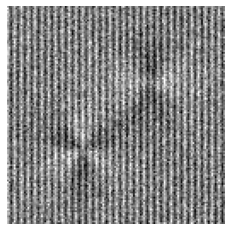

In [2]:
# read img
img = cv2.imread("sig_with_noise.png", 0)

# show img
fig = plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

前処理として与えられた画像について，フーリエ変換したものを取得する．今回は，[HW3](https://github.com/wakky927/image-processing/tree/main/HW3) の課題にて作成した二次元離散フーリエ変換(以下DDFT)のプログラムを使用する．なおDDFTの定義式は次の通り．

$$
F_{m_x, m_y} = \frac{1}{N_xN_y}\sum_{n_x=0}^{N_x-1}\sum_{n_y=0}^{N_y-1}f_{n_x, n_y}\exp\{-i(\frac{2\pi m_xn_x}{N_x}+\frac{2\pi m_yn_y}{N_y})\}
$$

ここで画像より，$N_x = 128, N_y = 128$ である．

In [3]:
# define DDFT function
def ddft(data, data2=None, mode="dft"):
    Ny, Nx = data.shape

    ReFmxmy = np.zeros_like(data).astype(float)
    ImFmxmy = np.zeros_like(data).astype(float)
    ReGnxmy = np.zeros_like(data).astype(float)
    ImGnxmy = np.zeros_like(data).astype(float)

    ReWpNx = [np.cos(2 * np.pi * i / Nx) for i in range(Nx)]
    ImWpNx = [np.sin(2 * np.pi * i / Nx) for i in range(Nx)]
    ReWpNy = [np.cos(2 * np.pi * i / Ny) for i in range(Ny)]
    ImWpNy = [np.sin(2 * np.pi * i / Ny) for i in range(Ny)]

    if mode == "dft":
        for nx in range(Nx):
            for my in range(Ny):
                for ny in range(Ny):
                    ReGnxmy[my][nx] += data[ny][nx] * ReWpNy[(my * ny) % Ny]
                    ImGnxmy[my][nx] += -data[ny][nx] * ImWpNy[(my * ny) % Ny]

        for mx in range(Nx):
            for my in range(Ny):
                for nx in range(Nx):
                    ReFmxmy[my][mx] += ReGnxmy[my][nx] * ReWpNx[(mx * nx) % Nx] + ImGnxmy[my][nx] * ImWpNx[(mx * nx) % Nx]
                    ImFmxmy[my][mx] += -ReGnxmy[my][nx] * ImWpNx[(mx * nx) % Nx] + ImGnxmy[my][nx] * ReWpNx[(mx * nx) % Nx]

        ReFmxmy /= Nx * Ny
        ImFmxmy /= Nx * Ny

    elif mode == "idft":
        for nx in range(Nx):
            for my in range(Ny):
                for ny in range(Ny):
                    ReGnxmy[my][nx] += data[ny][nx] * ReWpNy[(my * ny) % Ny] - data2[ny][nx] * ImWpNy[(my * ny) % Ny]
                    ImGnxmy[my][nx] += data[ny][nx] * ImWpNy[(my * ny) % Ny] + data2[ny][nx] * ReWpNy[(my * ny) % Ny]

        for mx in range(Nx):
            for my in range(Ny):
                for nx in range(Nx):
                    ReFmxmy[my][mx] += ReGnxmy[my][nx] * ReWpNx[(mx * nx) % Nx] - ImGnxmy[my][nx] * ImWpNx[(mx * nx) % Nx]
                    ImFmxmy[my][mx] += ReGnxmy[my][nx] * ImWpNx[(mx * nx) % Nx] + ImGnxmy[my][nx] * ReWpNx[(mx * nx) % Nx]

        ReFmxmy /= Nx * Ny
        ImFmxmy /= Nx * Ny

    return ReFmxmy, ImFmxmy

In [4]:
ReFm, ImFm = ddft(img, "dft")

In [5]:
ReFm2 = np.zeros_like(ReFm)
ImFm2 = np.zeros_like(ImFm)

ReFm2[0:64, 0:64], ReFm2[64:, 0:64], ReFm2[0:64, 64:], ReFm2[64:, 64:] = ReFm[64:, 64:], ReFm[0:64, 64:], ReFm[64:, 0:64], ReFm[0:64, 0:64]
ImFm2[0:64, 0:64], ImFm2[64:, 0:64], ImFm2[0:64, 64:], ImFm2[64:, 64:] = ImFm[64:, 64:], ImFm[0:64, 64:], ImFm[64:, 0:64], ImFm[0:64, 0:64]

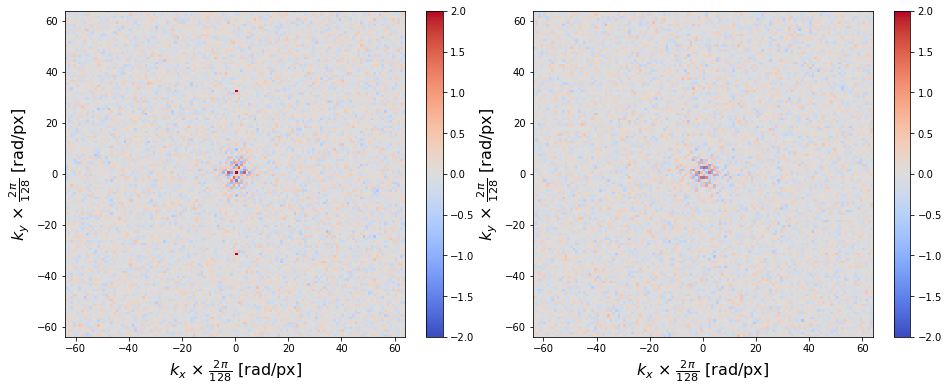

In [6]:
# show DDFT results
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(16.0, 6.0))
plt.subplots_adjust(wspace=0.1)

axes[0].set_xlabel(r"$k_x$ × $\frac{2\pi}{128}$ [rad/px]", fontsize=16)
axes[0].set_ylabel(r"$k_y$ × $\frac{2\pi}{128}$ [rad/px]", fontsize=16)
axes[1].set_xlabel(r"$k_x$ × $\frac{2\pi}{128}$ [rad/px]", fontsize=16)
axes[1].set_ylabel(r"$k_y$ × $\frac{2\pi}{128}$ [rad/px]", fontsize=16)

X, Y = np.mgrid[-64:65, -64:65]

ReFm_result = axes[0].pcolormesh(X, Y, ReFm2, cmap='coolwarm')
ImFm_result = axes[1].pcolormesh(X, Y, ImFm2, cmap='coolwarm')

ReFm_result.set_clim(vmin=-2, vmax=2)
ImFm_result.set_clim(vmin=-2, vmax=2)

cbar1 = fig.colorbar(ReFm_result, ax=axes[0])
cbar2 = fig.colorbar(ImFm_result, ax=axes[1])

plt.show()

今回与えられた画像について，周期的な縦縞が観測できる．この縦縞も雑音とみなすことから除去を試みる．上はDDFTの結果であり，左はDDFTの結果のうち実部を示したものであり，右は虚部を示したものである．また上記の波数区間は，DDFTを行った結果の配列に関して，第1象限と第3象限，第2象限と第4象限を入れ替えて表示している．

実部において，ピーク点は3つ存在しており，この内1点は原点であり他の2点はそれぞれ(0, -32), (0, 32)上でピークが観測できた．縦縞のノイズは実部にピークが現れることから，(0, -32), (0, 32)上の値を0にした上で逆DDFTを行い，縦縞の影響を低減することが期待される．この処理によって得られた画像を以下に示す．

In [7]:
ReFm[0, 32], ReFm[0, 96] = 0, 0

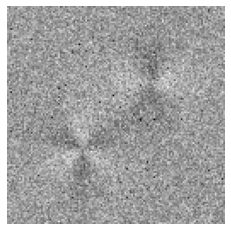

In [8]:
img_not_stripe, _ = ddft(ReFm, ImFm, "idft")

fig = plt.imshow(img_not_stripe, cmap='gray')
plt.axis('off')
plt.show()

得られた画像を確認すると，確かに縦縞が除去されていることがわかる．しかしながら依然として雑音は存在していることが伺える．

雑音が白色ノイズであると仮定し，ウィーナーフィルターを用いた．以下にその手順を示す．ただし画像の信号を $f$ とし，そのフーリエ変換を $F$ とする．

1. 得られた画像に対してDDFTを行い，波数空間の各位置に対する $|F(k_x, k_y)|^2$ を求める．
2. ノイズの性質を考慮して，$|N’(k_x,k_y)|^2$ を求める．今回は白色ノイズを仮定したため，適当な定数を与えるものとする．
3. 各位置に対する，$\Phi(k_x,k_y)$ を求める．ただし，本来のウィーナーフィルターは，振幅のみを変更し位相は変えないため，$\Phi(k_x,k_y) < 0$ のとき $\Phi(k_x,k_y) = 0$ とした．

$$
\Phi(k_x,k_y) = \frac{|F(k_x, k_y)|^2 - |N’(k_x,k_y)|^2}{|F(k_x, k_y)|^2}
$$

4. 以下の式から，逆DDFTを行い推定画像の信号を算出する．

$$
\widetilde{F}(k_x,k_y) = F(k_x, k_y) \Phi(k_x,k_y) \\
\hat{f}(x,y) = \mathcal{F}^{-1}(\widetilde{F}(k_x,k_y))
$$

手順1は既に実行しているため，手順2における $|N’(k_x,k_y)|^2$ として与える適当な定数を考える．先ほど縦縞を除去した画像信号について，$|F(k_x, k_y)|^2$ を以下に示す．

In [9]:
ReFm3 = np.zeros_like(ReFm)
ImFm3 = np.zeros_like(ImFm)

ReFm3[0:64, 0:64], ReFm3[64:, 0:64], ReFm3[0:64, 64:], ReFm3[64:, 64:] = ReFm[64:, 64:], ReFm[0:64, 64:], ReFm[64:, 0:64], ReFm[0:64, 0:64]
ImFm3[0:64, 0:64], ImFm3[64:, 0:64], ImFm3[0:64, 64:], ImFm3[64:, 64:] = ImFm[64:, 64:], ImFm[0:64, 64:], ImFm[64:, 0:64], ImFm[0:64, 0:64]

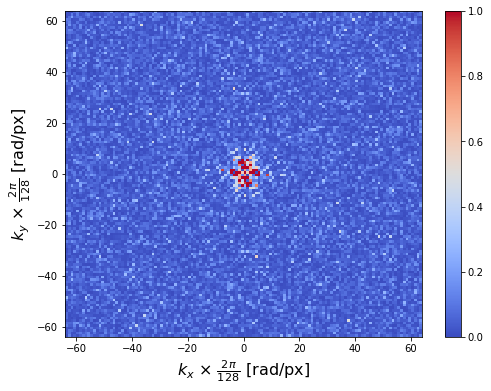

In [10]:
# show DDFT results
fig, ax = plt.subplots(figsize=(8.0, 6.0))

ax.set_xlabel(r"$k_x$ × $\frac{2\pi}{128}$ [rad/px]", fontsize=16)
ax.set_ylabel(r"$k_y$ × $\frac{2\pi}{128}$ [rad/px]", fontsize=16)

X, Y = np.mgrid[-64:65, -64:65]

F2 = ax.pcolormesh(X, Y, ReFm3**2+ImFm3**2, cmap='coolwarm')

F2.set_clim(vmin=0, vmax=1)

fig.colorbar(F2)

plt.show()

上図から低周波数領域でいくつかのピークを有することが確認でき，これらは本来の画像の特徴を表していることが予想できる．一方で高周波数領域では約0.2ほどの値が占めており，これを $|N’(k_x,k_y)|^2$ とすることで効果的なノイズ除去が期待される．

$|N’(k_x,k_y)|^2$ の値を0.02ずつ変化させた際の，ウィーナーフィルターを適用した画像を以下に示す．

In [11]:
def phi_func(f2, n2):
    p = (f2 - n2) / f2

    return np.where(p < 0, 0, p)

In [12]:
img_list = []

for i in range(1, 21):
    N = 0.02 * i
    phi = phi_func(ReFm**2+ImFm**2, N)
    f, _ = ddft(ReFm*phi, ImFm*phi, "idft")
    img_list.append(f)

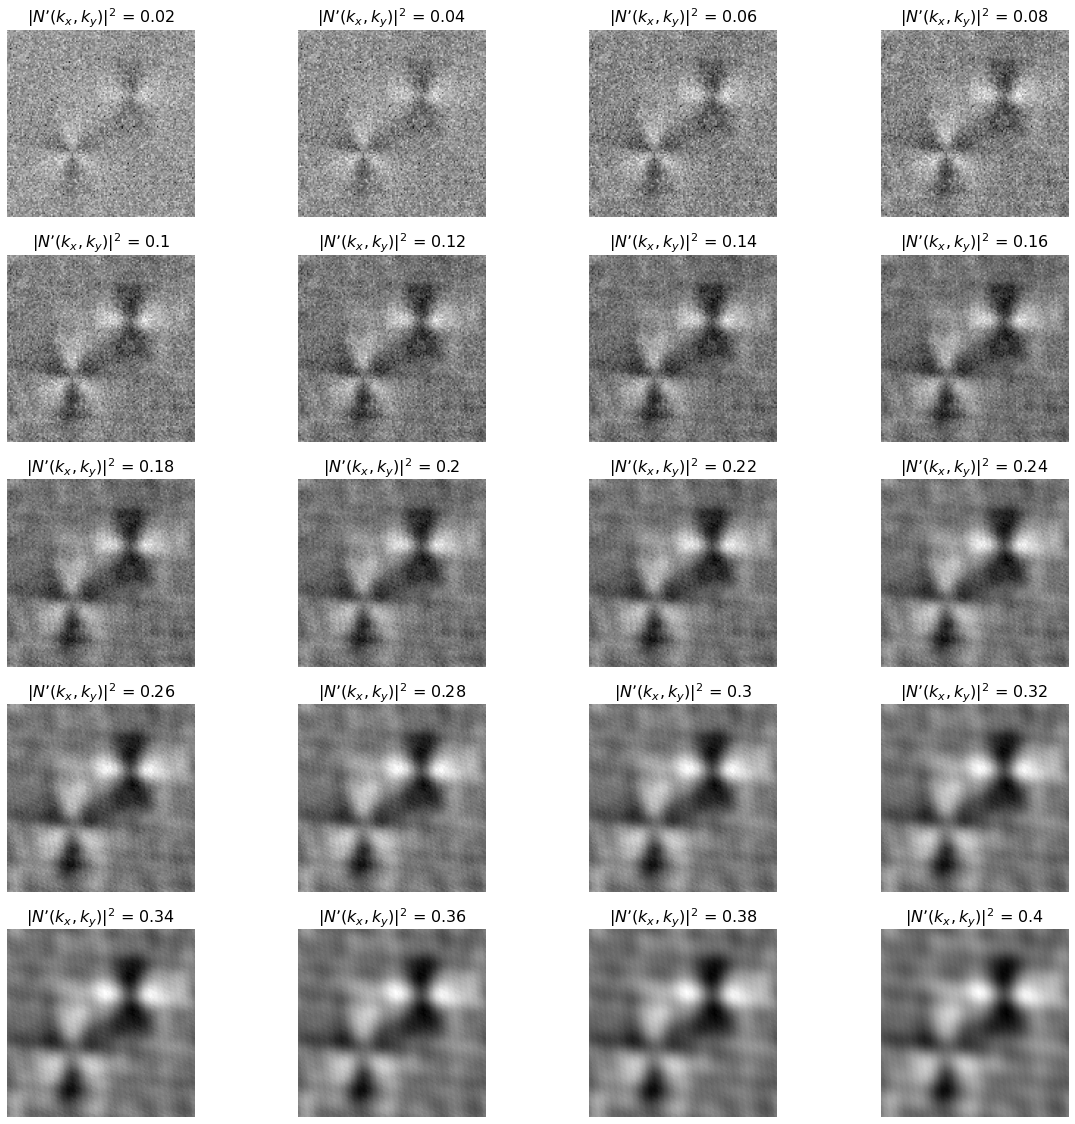

In [13]:
fig = plt.figure(figsize=(20.0, 20.0))

num = 0
while num < 20:
    num += 1
    plt.subplot(5, 4, num)
    plt.imshow(img_list[num-1], cmap='gray')
    plt.title(f"$|N’(k_x,k_y)|^2$ = {0.02*num}", fontsize=16)
    plt.axis('off')

plt.show()

結果から$|N’(k_x,k_y)|^2$ の値が大きくなるについれて，ノイズ除去の効果が画像に現れていることが確認される．一方で大きくしすぎた際に画像が平滑化の影響からぼやけてしまった結果が得られた．

比較のために元の画像を下に示す．

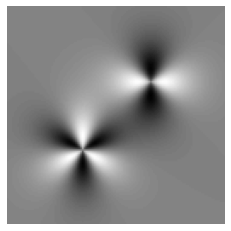

In [14]:
# read img
img_original = cv2.imread("signal.png", 0)

# show img
fig = plt.imshow(img_original, cmap='gray')
plt.axis('off')
plt.show()

この画像と比較すると0.2あたりの結果が類似していると考えられる．これを定性的に評価するために元画像との相互相関係数 $R$ を求めた．

$$
R = \frac{\sum (T'(x', y')\cdot I'(x+x', y+y'))}{\sqrt{\sum T'(x', y')^2\cdot\sum I'(x+x', y+y')^2}} \\
T'(x', y') = T(x', y') - \frac{1}{N_x N_y} \cdot \sum T(x'', y'') \\
I'(x+x', y+y') = I(x+x', y+y') - \frac{1}{N_x N_y} \cdot \sum I(x+x'', y+y'')
$$

In [15]:
result = []

for img_res in img_list:
    result.append(cv2.matchTemplate(img_original.astype(np.float32), img_res.astype(np.float32), cv2.TM_CCOEFF_NORMED)[0])

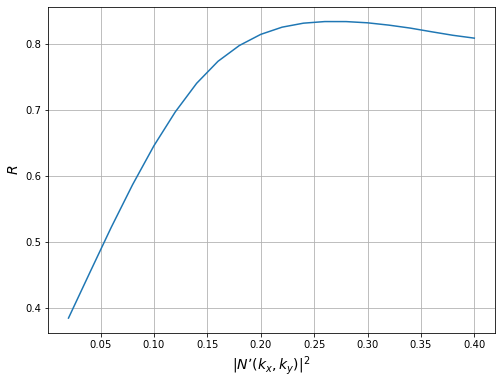

In [16]:
# show correlation results
fig = plt.figure(figsize=(8.0, 6.0))

plt.xlabel("$|N’(k_x,k_y)|^2$", fontsize=14)
plt.ylabel("$R$", fontsize=14)

plt.plot([0.02 * i for i in range(1, 21)], result)

plt.grid(which="both")

plt.show()

上のグラフの結果から0.26で最大値をとることがわかる．またこの値は先程効果的なノイズ除去が期待される0.2に近いことからも，妥当な値であるとみなせる．
